In [1]:
import glob
import chess_SL_E6_lib as lib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import chess
import numpy as np

In [2]:
_ = lib.fen_str_to_flat_tensor('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')

In [3]:
_ = lib.fen_str_to_3d_tensor('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')

In [4]:
MODEL_NUM = 6
MODEL_VERSION = 4

path = "../Data/DataTrain"

letters_in = 'abcdefghijk'
letters_out = 'adhl'

csv_files1 = []
csv_files2 = []

for let in letters_in:
    csv_files1.extend(glob.glob(f'{path}/Chess_Jan_{let}*'))

for let_ in letters_out:
    csv_files2.extend(glob.glob(f'{path}/Chess_Jan_{let_}*'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Models Trained
- V1 -> Predictor: tensor [64,64]
- V2 -> Predictor: tensor [64,64]
- V3 -> Predictor: tensor [64,64]
- V4 -> Predictor: tensor [64,64]

- E1 -> Epochs: 200, SGD(Learning Rate: 0.030, Momentum = 0.9), Loss: L1Loss, Training: "a*", Validation: "a*" |||| Vars: FEN, white_active, is_check |||| Predictor: CP
- E2 -> Epochs: 200, SGD(Learning Rate: 0.035, Momentum = 0.9), Loss: L1Loss, Training: "a*", Validation: "b*" |||| Vars: FEN, white_active, is_check |||| Predictor: CP
- E3 -> Epochs: 75, Adam(Learning Rate: 0.006, Mometum = 0.9), Loss: L1Loss, Training: "a|b*", Validation: "c|d*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E3.1 -> Epochs: 50, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c*", Validation: "d|e|f*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E3.2 -> Epochs: 40, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e|f|g*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E4.1 -> Epochs: 25, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e|f|g*" |||| Vars: FEN, white_active, is_capture |||| Predictor: CP
- E5.1 -> Epochs: 25, NN(1 conv, 2 FC), Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e*" |||| Vars: FEN |||| Predictor: CP
- E5.2 -> Epochs: 50, NN(1 conv, 2 FC), Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d|e*", Validation: "e|f*" |||| Vars: FEN |||| Predictor: CP
- E6.1 -> Epochs: 25, NN(2 conv, 2 FC), Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e*" |||| Vars: FEN |||| Predictor: CP
- E6.2 -> Epochs: 50, NN(2 conv, 2 FC), Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d|e*", Validation: "e|f*" |||| Vars: FEN |||| Predictor: CP

In [5]:
# Create a dataset
dataset1 = lib.ChessIterableDataset(csv_files1, chunksize = 50000)
dataset2 = lib.ChessIterableDataset(csv_files2, chunksize = 50000)

# Create a data loader
train_data_loader = DataLoader(dataset1, batch_size = 25000)
val_data_loader = DataLoader(dataset2, batch_size = 25000)

# Create a model
# model = lib.EvalNet()
model = torch.load(f'./models_EL/model_E6-2.pth')
model = model.to(device)

criterion = nn.L1Loss() # nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.035, momentum=0.9)

optimizer = optim.Adam(model.parameters(), lr=0.0061)

# Train the model
training_loss_history, validation_loss_history = lib.train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs=50)


Begin Training!
Epoch 1/50, Training Loss: 1.36298, Validation Loss: 1.33547
Epoch 2/50, Training Loss: 1.32681, Validation Loss: 1.39159
Epoch 3/50, Training Loss: 1.32223, Validation Loss: 1.35281
Epoch 4/50, Training Loss: 1.31413, Validation Loss: 1.36666
Epoch 5/50, Training Loss: 1.31136, Validation Loss: 1.32990
Epoch 6/50, Training Loss: 1.30429, Validation Loss: 1.35191
Epoch 7/50, Training Loss: 1.30573, Validation Loss: 1.30570
Epoch 8/50, Training Loss: 1.29511, Validation Loss: 1.34067
Epoch 9/50, Training Loss: 1.29733, Validation Loss: 1.31098
Epoch 10/50, Training Loss: 1.29033, Validation Loss: 1.39717
Epoch 11/50, Training Loss: 1.28882, Validation Loss: 1.29900
Epoch 12/50, Training Loss: 1.28482, Validation Loss: 1.36996
Epoch 13/50, Training Loss: 1.28173, Validation Loss: 1.32245
Epoch 14/50, Training Loss: 1.28415, Validation Loss: 1.28602
Epoch 15/50, Training Loss: 1.27559, Validation Loss: 1.32453
Epoch 16/50, Training Loss: 1.27420, Validation Loss: 1.28016
E

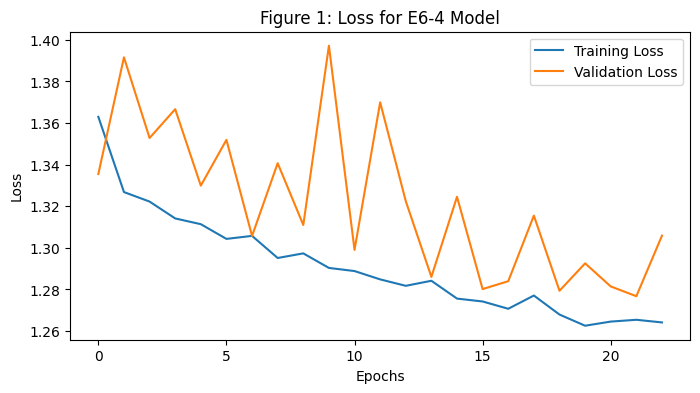

In [6]:
torch.save(model, f'model_E{MODEL_NUM}-{MODEL_VERSION}.pth')

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(training_loss_history, label = 'Training Loss')
plt.plot(validation_loss_history, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0, None)
plt.title(f'Figure 1: Loss for E{MODEL_NUM}-{MODEL_VERSION} Model')
plt.legend()
plt.savefig(f'Loss_E{MODEL_NUM}-{MODEL_VERSION}.png')
plt.show()



# NOTE TO SELF - TEST NEW STOCHASTIC PREDICTION FUNCTION

In [7]:
import pickle

pickle.dump(training_loss_history, open(f'pickle/training_loss_history_E{MODEL_NUM}-{MODEL_VERSION}.pkl', 'wb'))
pickle.dump(validation_loss_history, open(f'pickle/validation_loss_history_E{MODEL_NUM}-{MODEL_VERSION}.pkl', 'wb'))

In [ ]:
model_loaded = torch.load(f'model_E{MODEL_NUM}-{MODEL_VERSION}.pth')

In [ ]:
board = chess.Board()

e2e4


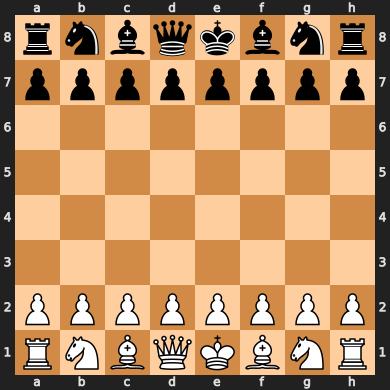

In [ ]:
move = lib.predict(model_loaded, board.fen())
print(move)
board

In [ ]:
board.push_uci(move)
board

TypeError: object of type 'Move' has no len()

In [ ]:
move = lib.predict(model_loaded, board.fen())

In [ ]:
move = 'e4f6'

In [ ]:
# TODO : make prediction function
# TODO : speed up